# Process Bigraph Schema
This tutorial covers Process Bigraph Schema, starting with single `store` and increasing in detail as you scroll towards the bottom. It uses the libraries [bigraph-schema](https://github.com/vivarium-collective/bigraph-schema) for the schema validation and type registry and [bigraph-viz](https://github.com/vivarium-collective/bigraph-viz) for visualization.

## Bigraph-schema and Bigraph-viz

[Bigraph-schema](https://github.com/vivarium-collective/bigraph-schema) is a serializable type schema for Process Bigraph simulations. From this library, we will use the `validate_schema` method to check our schemas, and `fill` to fill in missing details to prepare the schema for simulation. We will also use the `type_registry` to access different schemas, and register new ones.

[Bigraph-viz](https://github.com/vivarium-collective/bigraph-viz) is an easy-to-use plotting tool for compositional bigraph schema, built on top of Graphviz. It reads raw Compositional Bigraph Schemas and generates a figure that can be displayed in a notebook or saved to file. Bigraph-viz's main plotting function is `plot_bigraph` for the bigraph structure. `plot_flow` and `plot_multitimestep` make plots of process orchestration.

### Installation

In [1]:
# !pip install bigraph-schema
# !pip install bigraph-viz
!pip freeze | grep bigraph

-e git+https://github.com/vivarium-collective/bigraph-schema.git@0c90a88ffe83c4b88d057e28a4f30fb19ef0263e#egg=bigraph_schema
bigraph-viz==0.0.31
-e git+https://github.com/vivarium-collective/process-bigraph.git@6517fc88103bc3cfaad4d5a1fdbd9131015360d4#egg=process_bigraph


### Imports

In [5]:
# from bigraph_viz import plot_bigraph, plot_flow, plot_multitimestep, pf
from bigraph_viz.dict_utils import replace_regex_recursive
from bigraph_viz.diagram import plot_bigraph

plot_settings = {
    # 'remove_process_place_edges': True
}
save_images = False
if save_images:
    plot_settings.update({'out_dir': 'out','dpi': '250'})

## Stores

### Simple stores
A store can be declared in a JSON dictionary with the store's name mapped to its `value`. 

Writing out/simple_store


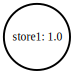

In [6]:
simple_store_state = {
    'store1': 1.0,
}
plot_bigraph(simple_store_state, **plot_settings, show_values=True, filename='simple_store')

To include values *and* types in a node label, you can instead have the store name map to a dict with `_value` and `_type` keys.

Writing out/store


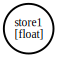

In [7]:
typed_store_spec = {
    'store1': {
        '_value': 1.0, 
        '_type': 'float',
    },
}
plot_bigraph(typed_store_spec, **plot_settings, show_values=True, show_types=True, filename='store')

### Hierarchy
A hierarchy is a place graph of nested stores. Stores can be placed within stores using JSON dictionary nesting.

Writing out/hierarchy


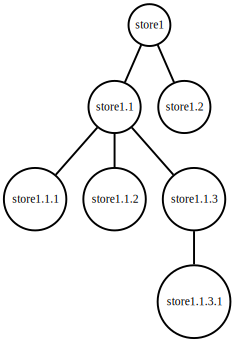

In [8]:
hierarchy_spec = {
    'store1': {
        'store1.1': {
            'store1.1.1': 'Any',
            'store1.1.2': 'Any',
            'store1.1.3': {
                'store1.1.3.1': 'Any',
            },
        },
        'store1.2': 'Any',
    },
}
plot_bigraph(hierarchy_spec, **plot_settings, filename='hierarchy')

## Processes

### Single process
Processes require ports, which are declared with the `_ports` key mapped to a dict that has port names matched to types.

Writing out/process


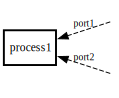

In [14]:
process_spec = {
    'process1': {
        '_type': 'edge',
        '_inputs': {
            'port1': 'Any',
            'port2': 'Any',
        },
    },
}
plot_bigraph(process_spec, **plot_settings, rankdir='RL', filename='process')

### Multiple processes

Writing out/multiple_processes


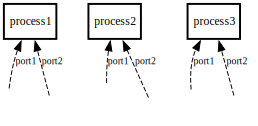

In [15]:
process_schema = {
    '_type': 'process',
    '_inputs': {
        'port1': 'Any',
        'port2': 'Any'
    }
}

processes_spec = {
    'process1': process_schema,
    'process2': process_schema,
    'process3': process_schema,
}
plot_bigraph(processes_spec, **plot_settings, rankdir='BT', filename='multiple_processes')

## Wires
To connect a process's ports to stores, add wiring with a `_wires` key that maps port names to relative paths in the store hierarchy. The ports used by the wires need to match the ports in the schema.

Writing out/wires


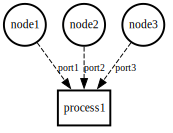

In [19]:
connected_process_spec = {
    'process1': {
        '_type': 'edge',
        '_inputs': {
            'port1': 'float',
            'port2': 'int',
            'port3': 'int',
        },
        'inputs': {
            'port1': ['node1'],
            'port2': ['node2'],
            'port3': ['node3'],
        }
    },
    'node1': 'float',  # TODO -- shouldn't these fill?
    'node2': 'int',
    'node3': 'int',
}
plot_bigraph(connected_process_spec, **plot_settings, filename='wires')

### Advanced wiring
**TODO**

## Composites

### Flat composite
A flat composite connects stores with multiple connected processes, without nesting.

Writing out/flat_composite


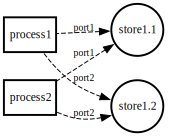

In [22]:
flat_composite_spec = {
    'store1.1': 'float',
    'store1.2': 'int',
    'process1': {
        '_type': 'process',
        'outputs': {
            'port1': ['store1.1'],
            'port2': ['store1.2'],
        }
    },
    'process2': {
        '_type': 'process',
        'inputs': {
            'port1': ['store1.1'],
            'port2': ['store1.2'],
        }
    },
}
plot_bigraph(flat_composite_spec, **plot_settings, rankdir='RL', filename='flat_composite')

### Nested composite
A nested composite has store hierarchies with multiple connected processes.

In [24]:
nested_composite_spec = {
    'store1': {
        'store1.1': 'float',
        'store1.2': 'int',
        'process1': {
            '_type': 'process',
            'inputs': {
                'port1': ['store1.1'],
                'port2': ['store1.2'],
            }
        },
        'process2': {
            '_type': 'proces',
            'outputs': {
                'port1': ['store1.1'],
                'port2': ['store1.2'],
            }
        },
    },
    'process3': {
        '_type': 'process',
        'inputs': {
            'port1': ['store1'],
        }
    }
}
plot_bigraph(nested_composite_spec, **plot_settings, filename='nested_composite')

TypeError: argument of type 'NoneType' is not iterable

### Composite process
Composite processes are processes with internal stores and internal processes, which can run as their own simulation. The composite process has schema, allowing it to connect to a super-simulation. This allows for improved distributed computation, with composite processes able to run on their own computer and syncronize to the super-simulation via message passing.

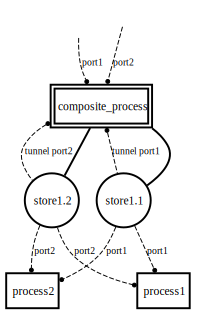

In [11]:
composite_process_spec = {
    'composite_process': {
        'store1.1': 'Any',
        'store1.2': 'Any',
        'process1': {
            '_type': 'python_process:temporal',
            'wires': {
                'port1': 'store1.1',
                'port2': 'store1.2',
            }
        },
        'process2': {
            '_type': 'python_process:temporal',
            'wires': {
                'port1': 'store1.1',
                'port2': 'store1.2',
            }
        },
        '_ports': {
            'port1': 'Any', 
            'port2': 'Any', 
        },
        '_tunnels': {
            'port1': 'store1.1',
            'port2': 'store1.2',
        }
    }
}
plot_bigraph(composite_process_spec, **plot_settings, filename='composite_process')

## Orchestration

In [12]:
plot_settings2={}
if save_images:
    plot_settings2.update({
        'out_dir': 'out',
        'dpi': '250'
    })

### Multi-timestepping

Temporal processes can be run by multi-timestepping, with each process updating the state according to its `sync_state` state, which it can update adaptively.

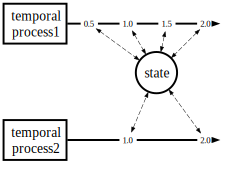

In [13]:
multitimestep_spec = {
    'temporal process2': {
        '_ports': {'port1': 'Any'},
        'wires': {'port1': 'state'},
        '_sync_step': 1.0,
    },
    'temporal process1': {
        '_ports': {'port1': 'Any'},
        'wires': {'port1': 'state'},
        '_sync_step': 0.5,
    },
}
multitimestep_spec = replace_regex_recursive(multitimestep_spec)
plot_multitimestep(multitimestep_spec, total_time=2.0, **plot_settings2, filename='multitimestep')

### Flows

A directed acyclic graph (DAG) – a type of workflow that declares the dependencies between processes. A flow run is not temporal, and the order is entirely based on dependencies. It can triggered between time steps, running the steps in the order as determined by their dependencies.

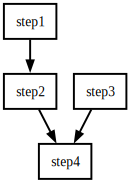

In [14]:
flow = {
    'step1': {
        '_type': 'step_process',
        '_ports': {},
        '_depends_on': [], 
    },
    'step2': {
        '_type': 'step_process',
        '_ports': {},
        '_depends_on': 'step1', 
    },
    'step3': {
        '_type': 'step_process',
        '_ports': {},
        '_depends_on': [], 
    },
    'step4': {
        '_type': 'step_process',
        '_ports': {},
        '_depends_on': ['step2', 'step3'], 
    },
}

plot_flow(flow, **plot_settings2, filename='flow')

## Examples

### Multiscale map of a cell

Bigraphs can represent the hierarchical nesting of cellular structures. Below is a multiscale map of a cell from [Qin et al. A multi-scale map of cell structure fusing protein images and interactions. Nature. 2021.](https://pubmed.ncbi.nlm.nih.gov/34819669/)

Writing out/cell_hierarchy


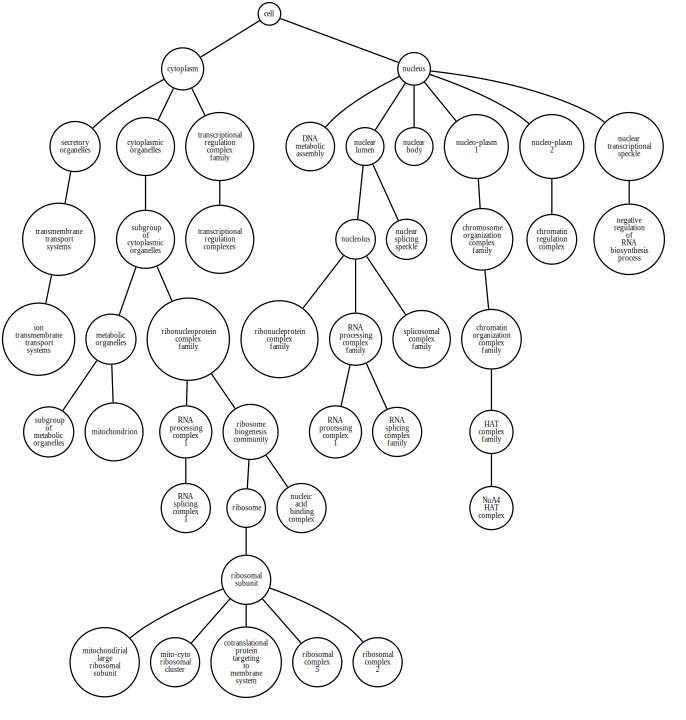

In [25]:
music_map = {
    'cell': {
        'cytoplasm': {
            'secretory organelles': {
                'transmembrane transport systems': {
                    'ion transmembrane transport systems': {}}},
            'cytoplasmic organelles': {
                'subgroup of cytoplasmic organelles': {
                    'metabolic organelles': {
                        'subgroup of metabolic organelles': {},
                        'mitochondrion': {}},
                    'ribonucleoprotein complex family': {
                        'RNA processing complex 1': {'RNA splicing complex 1': {}},
                        'ribosome biogenesis community': {
                            'ribosome': {
                                'ribosomal subunit': {
                                    'mitochondirial large ribosomal subunit': {
                                        # 'large ribosomal subunit subcomplex 1': {}
                                    },
                                    'mito-cyto ribosomal cluster': {},
                                    'cotranslational protein targeting to membrane system': {},
                                    'ribosomal complex 5': {},
                                    'ribosomal complex 2': {}}},
                            'nucleic acid binding complex': {}}}}},
            'transcriptional regulation complex family': {
                'transcriptional regulation complexes': {}}},
        'nucleus': {
            'DNA metabolic assembly': {},
            'nuclear lumen': {
                'nucleolus': {
                    'ribonucleprotein complex family': {},
                    'RNA processing complex family': {
                        'RNA processing complex 1': {},
                        'RNA splicing complex family': {}},
                    'splicosomal complex family': {}},
                'nuclear splicing speckle': {}},
            'nuclear body': {},
            'nucleo-plasm 1': {
                'chromosome organization complex family': {
                    'chromatin organization complex family': {
                        'HAT complex family': {
                            'NuA4 HAT complex': {}}}}},
            'nucleo-plasm 2': {
                'chromatin regulation complex': {}},
            'nuclear transcriptional speckle': {
                'negative regulation of RNA biosynthesis process': {}}}}}
music_map1 = replace_regex_recursive(music_map)
plot_bigraph(music_map1, **plot_settings, filename='cell_hierarchy')

In [26]:
music_map

{'cell': {'cytoplasm': {'secretory organelles': {'transmembrane transport systems': {'ion transmembrane transport systems': {}}},
   'cytoplasmic organelles': {'subgroup of cytoplasmic organelles': {'metabolic organelles': {'subgroup of metabolic organelles': {},
      'mitochondrion': {}},
     'ribonucleoprotein complex family': {'RNA processing complex 1': {'RNA splicing complex 1': {}},
      'ribosome biogenesis community': {'ribosome': {'ribosomal subunit': {'mitochondirial large ribosomal subunit': {},
         'mito-cyto ribosomal cluster': {},
         'cotranslational protein targeting to membrane system': {},
         'ribosomal complex 5': {},
         'ribosomal complex 2': {}}},
       'nucleic acid binding complex': {}}}}},
   'transcriptional regulation complex family': {'transcriptional regulation complexes': {}}},
  'nucleus': {'DNA metabolic assembly': {},
   'nuclear lumen': {'nucleolus': {'ribonucleprotein complex family': {},
     'RNA processing complex family': 

In [27]:
import copy

transcription_process = {
    '_ports': {
        'RNA processing': 'Any',
        'regulation': 'Any',
        'nucleic acids': 'Any',
        'negative regulation': 'Any'
    },
    'wires': {
        'RNA processing': [
            'nucleus', 'nuclear lumen', 'nucleolus', 'RNA processing complex family'],
        'regulation': [
            'cytoplasm', 'transcriptional regulation complex family', 'transcriptional regulation complexes'],
        'nucleic acids': [
            'cytoplasm', 'cytoplasmic organelles', 'subgroup of cytoplasmic organelles', 
            'ribonucleoprotein complex family', 'ribosome biogenesis community', 'nucleic acid binding complex'],
        'negative regulation': [
            'nucleus', 'nuclear transcriptional speckle', 'negative regulation of RNA biosynthesis process'],
    }
}

translation_process = {
    '_ports': {
        'ribosomes': 'Any',
        'membrane': 'Any'
    },
    'wires': {
        'ribosomes': [
            'cytoplasm', 'cytoplasmic organelles', 'subgroup of cytoplasmic organelles', 'ribonucleoprotein complex family', 'ribosome biogenesis community', 'ribosome'],
        # 'membrane': ['],
    }
}

metabolism_process = {
    '_ports': {
        'organelles': 'Any',
        'mitochondrion': 'Any',
        'ion transport': 'Any',
    },
    'wires': {
        'organelles': [
            'cytoplasm', 'cytoplasmic organelles', 'subgroup of cytoplasmic organelles', 'metabolic organelles', ],
        'mitochondrion': [
            'cytoplasm', 'cytoplasmic organelles', 'subgroup of cytoplasmic organelles', 'metabolic organelles', 'mitochondrion'],
        'ion transport': [
            'cytoplasm', 'secretory organelles', 'transmembrane transport systems', 'ion transmembrane transport systems'],
    }
}

cell_cycle_process = {
    '_ports': {
        'DNA': 'Any',
        'chromosome': 'Any',
        'chromatin': 'Any',
    },
    'wires': {        
        'DNA': ['nucleus', 'DNA metabolic assembly'],
        'chromosome': ['nucleus', 'nucleo-plasm 1', 'chromosome organization complex family',],
        'chromatin': ['nucleus', 'nucleo-plasm 1', 'chromosome organization complex family', 'chromatin organization complex family'],
    }
}

signalling_process = {
    '_ports': {
        'transport': 'Any',
        'trancript regulation': 'Any',
    },
    'wires': {        
        'transport': [
            'cytoplasm', 'secretory organelles', 'transmembrane transport systems'],
        'trancript regulation': [
            'cytoplasm', 'transcriptional regulation complex family', 'transcriptional regulation complexes'],
    }
}

protein_transport_process = {
    '_ports': {
        'transmembrane transport': 'Any',
        'secretory': 'Any',
        'cotranslation': 'Any',
    },
    'wires': {        
        'transmembrane transport': [
            'cytoplasm', 'secretory organelles', 'transmembrane transport systems'],
        'secretory': [
            'cytoplasm', 'secretory organelles'],
        'cotranslation': [
            'cytoplasm', 'cytoplasmic organelles', 'subgroup of cytoplasmic organelles', 'ribonucleoprotein complex family', 
            'ribosome biogenesis community', 'ribosome', 'ribosomal subunit', 'cotranslational protein targeting to membrane system']
    }
}

rna_processing_process = {
    '_ports': {
        'processing complex': 'Any',
    },
    'wires': {        
        'processing complex': [
            'nucleus', 'nuclear lumen', 'nucleolus', 'RNA processing complex family'],
    }
}

# compose schema
music_map['cell']['transcription'] = transcription_process
music_map['cell']['translation'] = translation_process
music_map['cell']['metabolism'] = metabolism_process
music_map['cell']['cell cycle'] = cell_cycle_process
music_map['cell']['signalling'] = signalling_process
music_map['cell']['protein transport'] = protein_transport_process
music_map['cell']['RNA processing'] = rna_processing_process

music_map2 = replace_regex_recursive(music_map)

# plot
plot_settingsx = copy.deepcopy(plot_settings)
plot_settingsx['label_margin'] = '0.02'
plot_settingsx['node_border_colors'] = {
    ('cell', 'translation'): 'blue',
    ('cell', 'transcription'): 'blue',
    ('cell', 'metabolism'): 'blue',
    ('cell', 'cell<br/>cycle'): 'blue',
    ('cell', 'signalling'): 'blue',
    ('cell', 'protein<br/>transport'): 'blue',
    ('cell', 'RNA<br/>processing'): 'blue',
}
# plot_settingsx.update({'out_dir': 'out','dpi': '250'})
plot_bigraph(music_map2, **plot_settingsx, filename='cell_hierarchy_functions')

TypeError: plot_bigraph() got an unexpected keyword argument 'node_border_colors'

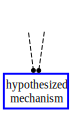

In [18]:
new_process = {
    'hypothesized mechanism': {
        '_ports': {
            '1': 'Any',
            '2': 'Any',
        }
    }
}

new_process = replace_regex_recursive(new_process)

# plot
plot_settingsx = copy.deepcopy(plot_settings)
plot_settingsx['label_margin'] = '0.03'
plot_settingsx['node_border_colors'] = {
    ('hypothesized<br/>mechanism',): 'blue',
}
plot_settingsx['port_labels'] = False
plot_bigraph(new_process, **plot_settingsx, filename='hypothesized_mechanism')

### Cell structure and function
Processes represent their functions, we show a more minimal cell structure with added processes.

Writing out/cell


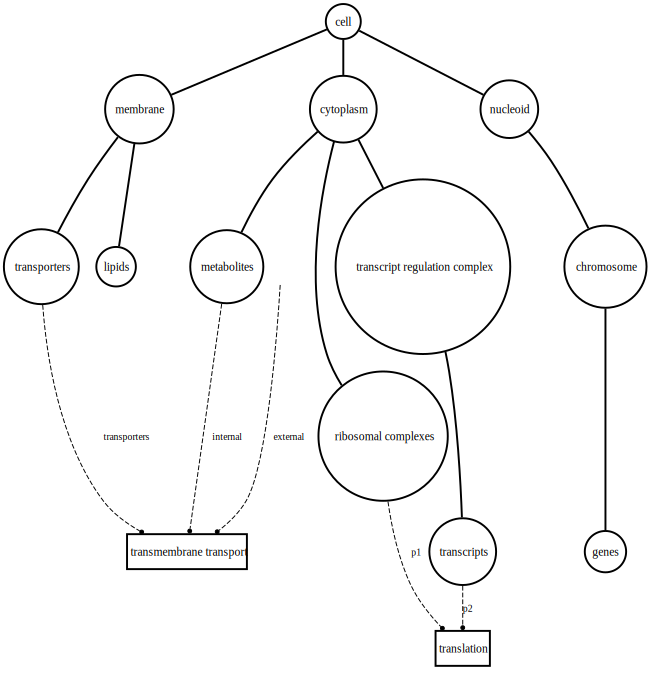

In [19]:
cell_struct_func = {
    'cell': {
        'membrane': {
            'transporters': 'concentrations',
            'lipids': 'concentrations',
            'transmembrane transport': {
                '_value': {
                    '_process': 'transport URI',
                    '_config': {'parameter': 1}
                },
                'wires': {
                    'transporters': 'transporters',
                    'internal': ['..', 'cytoplasm', 'metabolites']},
                '_ports': {
                    'transporters': 'concentrations',
                    'internal': 'concentrations',
                    'external': 'concentrations'
                }
            }
        },
        'cytoplasm': {
            'metabolites': {
                '_value': 1.1,
                '_type': 'concentrations'
            },
            'ribosomal complexes': {
                '_value': 2.2,
                '_type': 'concentrations'
            },
            'transcript regulation complex': {
                '_value': 0.01,
                'transcripts': {
                    '_value': 0.1,
                    '_type': 'concentrations'
                }
            },
            'translation': {
                'wires': {
                    'p1': 'ribosomal complexes',
                    'p2': ['transcript regulation complex', 'transcripts']}}},
        'nucleoid': {
            'chromosome': {
                'genes': 'sequences'
            }
        }
    }
}
plot_bigraph(cell_struct_func, remove_process_place_edges=True, out_dir='out', filename='cell')

### Whole-cell *E. coli* model

We here plot the processes and wiring of a whole-cell model of *E. coli* from [Macklin et al. Simultaneous cross-evaluation of heterogeneous E. coli datasets via mechanistic simulation. Science. 2020.](https://pubmed.ncbi.nlm.nih.gov/32703847/)

In [20]:
ecoli = { 
    'chromosome-structure': { 
        'wires': {
            'fragmentBases': ('bulk',),
            'molecules': ('bulk',),
            'active_tfs': ('bulk',),
            'subunits': ('bulk',),
            'amino_acids': ('bulk',),
            'active_replisomes': ('unique', 'active_replisome'),
            'oriCs': ('unique', 'oriC'),
            'chromosome_domains': ('unique', 'chromosome_domain'),
            'active_RNAPs': ('unique', 'active_RNAP'),
            'RNAs': ('unique', 'RNA'),
            'active_ribosome': ('unique', 'active_ribosome'),
            'full_chromosomes': ('unique', 'full_chromosome'),
            'promoters': ('unique', 'promoter'),
            'DnaA_boxes': ('unique', 'DnaA_box')
        }
    },
    'metabolism': { 
        'wires': {
            'metabolites': ('bulk',),
            'catalysts': ('bulk',),
            'kinetics_enzymes': ('bulk',),
            'kinetics_substrates': ('bulk',),
            'amino_acids': ('bulk',),
            'environment': ('environment',),
            'amino_acids_total': ('bulk',)
        }
    },
    'tf-binding': { 
        'wires': {
            'promoters': ('unique', 'promoter'),
            'active_tfs': ('bulk',),
            'active_tfs_total': ('bulk',),
            'inactive_tfs_total': ('bulk',),
        }
    },
    'transcript-initiation': { 
        'wires': {
            'environment': ('environment',),
            'full_chromosomes': ('unique', 'full_chromosome'),
            'RNAs': ('unique', 'RNA'),
            'active_RNAPs': ('unique', 'active_RNAP'),
            'promoters': ('unique', 'promoter'),
            'molecules': ('bulk',),
        }
    },
    'transcript-elongation': { 
        'wires': {
            'environment': ('environment',),
            'RNAs': ('unique', 'RNA'),
            'active_RNAPs': ('unique', 'active_RNAP'),
            'molecules': ('bulk',),
            'bulk_RNAs': ('bulk',),
            'ntps': ('bulk',),
        }
    },
    'rna-degradation': { 
        'wires': {
            'charged_trna': ('bulk',),
            'bulk_RNAs': ('bulk',),
            'nmps': ('bulk',),
            'fragmentMetabolites': ('bulk',),
            'fragmentBases': ('bulk',),
            'endoRnases': ('bulk',),
            'exoRnases': ('bulk',),
            'subunits': ('bulk',),
            'molecules': ('bulk',),
            'RNAs': ('unique', 'RNA'),
            'active_ribosome': ('unique', 'active_ribosome'),
        }
    },
    'polypeptide-initiation': { 
        'wires': {
            'environment': ('environment',),
            'active_ribosome': ('unique', 'active_ribosome'),
            'RNA': ('unique', 'RNA'),
            'subunits': ('bulk',)
        }
    },
    'polypeptide-elongation': { 
        'wires': {
            'environment': ('environment',),
            'active_ribosome': ('unique', 'active_ribosome'),
            'molecules': ('bulk',),
            'monomers': ('bulk',),
            'amino_acids': ('bulk',),
            'ppgpp_reaction_metabolites': ('bulk',),
            'uncharged_trna': ('bulk',),
            'charged_trna': ('bulk',),
            'charging_molecules': ('bulk',),
            'synthetases': ('bulk',),
            'subunits': ('bulk',),
            'molecules_total': ('bulk',),
            'amino_acids_total': ('bulk',),
            'charged_trna_total': ('bulk',),
            'uncharged_trna_total': ('bulk',)
        }
    },
    'complexation': {
        'wires': {
            'molecules': ('bulk',), 
        }
    },
    'two-component-system': { 
        'wires': {
            'molecules': ('bulk',)
        }
    },
    'equilibrium': {
        'wires': {
            'molecules': ('bulk',)
        }
    },
    'protein-degradation': { 
        'wires': {
            'metabolites': ('bulk',),
            'proteins': ('bulk',)
        }
    },
    'chromosome-replication': { 
        'wires': {
            'replisome_trimers': ('bulk',),
            'replisome_monomers': ('bulk',),
            'dntps': ('bulk',),
            'ppi': ('bulk',),
            'active_replisomes': ('unique', 'active_replisome'),
            'oriCs': ('unique', 'oriC'),
            'chromosome_domains': ('unique', 'chromosome_domain'),
            'full_chromosomes': ('unique', 'full_chromosome'),
            'environment': ('environment',)
        }
    },
    'unique': {
        'chromosome_domain': {},
        'full_chromosome': {},
        'oriC': {},
        'active_replisome': {},
        'RNA': {},
        'active_ribosome': {},
        'DnaA_box': {},
        'promoter': {},
    },
    'bulk': {},
    'environment': {},
}
node_groups = [[ #line up the top nodes for visual effect
        ('unique',), ('bulk',), ('environment',), 
    ],
]
# plot settings
plot_settings_ecoli = {
    'remove_process_place_edges': True,
    'rankdir': 'RL',
    'dpi': '100',
    'out_dir': 'out',
}
fig = plot_bigraph(ecoli, **plot_settings_ecoli, node_groups=node_groups, filename='ecoli')

Writing out/ecoli


[See E. coli wiring diagram](https://github.com/vivarium-collective/bigraph-viz/blob/main/doc/_static/ecoli.png?raw=true)